### Python Libraries and Packages

In [1]:
### Imports ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.backends.backend_pdf import PdfPages
import math as m 
import os
import sys
import re

from astropy.utils import data
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import ascii
from astropy.table import Table

import warnings
warnings.filterwarnings('ignore')

### Global Parameters

In [2]:
# directory where the data are located and the files are to be written
datadir = '/Users/jane/Desktop/MAJORS/analysis/s138/'
 
# name of the input temperature map/FITS file
temp_fitsfilename = 's138_temp_regrid.fits'
 
# Name of the spectral data cubes on which to perform gaussian fitting
hco_spec_filename='s138_HCO+_smo.fits'       # input fits file name
hcn_spec_filename='s138_HCN_smo.fits'        # input fits file name
 
# path to the radex molecular data files
radexpath = '/Users/jane/Desktop/Radex/data/'
 
# extension to the molecular data files
extension = '.dat'
 
# path to the radex executable program
radexexec = '/Users/jane/Desktop/Radex/bin/radex'
 
# how executable command will be called
# os.system(radexexec+ '<' +radexpath+'/'+inputFile+ '> /dev/null' ) 
 
##################################################
 
# Parameters for the Gaussian fitting.  Change them for each new source
 
vel_guess = -52   # The initial guess for the centroid velocity of the gaussian fit
peak_guess = 4    # the initial guess for the maximum line strength (sets the yscaling of the plots)
dv_min = 1        # set a minimum acceptable line width
dv_max = 10       # set a maximum acceptable line width
snr_min = 3.0     # set a minumum acceptable SNR
 
# set the range of pixels in the x direction over which to loop
#min_xpix = 0      # s138 all
#max_xpix = 49     # s138 all
min_xpix = 2     # s138 small
max_xpix = 11    # s138 small
 
# set the range of pixels in the y direction over which to loop
#min_ypix = 0      # s138 all
#max_ypix = 46     # s138 all
min_ypix = 38    # s138 small
max_ypix = 46    # s138 small
 
#################################################
 
# density for the RADEX models
nh2 = 1.0e5      # nH2 cm^-3
 
##################################################
 
# Names of various output files.  YOU ONLY NEED TO CHANGE THESE IF YOU WANT
# DIFFERENT NAMES THAN THE DEFAULT ONES
 
# name of the output ascii text file containing the dust temperature
temp_asciifile = 'temp.txt'
 
# Name the name of the output ascii files with the Gaussian fits
hco_gauss_outfile = 'hco+_gaussfits.txt' # file name of the gaussian fit results
hcn_gauss_outfile = 'hcn_gaussfits.txt' # file name of the gaussian fit results
 
# Name the name of the output files with the Gaussian fits plots
hco_gauss_plots = 'hco+_gaussfits_plots.pdf' # file name of the gaussian fit plot
hcn_gauss_plots = 'hcn_gaussfits_plots.pdf' # file name of the gaussian fit plot
 
# Name of the RADEX input files that the code creates
radexhcoinp = 'radexHCO+.inp'
radexhcninp = 'radexHCN.inp'
 
# Name of the RADEX output files
radexhcoout = 'radexHCO+.out'
radexhcnout = 'radexHCN.out'
 
# Name of the output files which contain position and column density for all pixels
hcocolden   = 'HCO+_colden.txt'
hcncolden   = 'HCN_colden.txt'
coldenratio = 'ColDenRatio.txt'

### Gaussian fits

In [23]:
#JCMT efficiency at 230 GHz to convert TA* to Tmb
eta = 0.6

#### Fit HCO+
# retrieving the source data and information
datfile = fits.open(datadir+hco_spec_filename)
cube = SpectralCube.read(datfile)
wcs = WCS(datfile[0].header) # vel and position info from WCS in header

# extract the world coordinates of all the pixels using the world property, 
# which returns the spectral axis then the two positional coordinates in reverse order 
# (in the same order as the data indices - i.e. spectral axis, Y, X). 
velo, lat, long  = cube.world[:] 

# convert the velocity units from m/s (in the fits header) to km/s
cube2 = cube.with_spectral_unit(u.km / u.s)

# Make a sub-cube using a part of the spectrum that is free of spectral line emission 
# This will be used to calculate the noise in each spectrum
linefree = cube2.spectral_slab((vel_guess*u.km / u.s) + (20*u.km / u.s),(vel_guess*u.km / u.s) + (100*u.km / u.s))

# print column headers to screen
#print("HCO+")
#print("x  y          Glat.                 Glong.           TA   Tmb    V     Sig   Fwhm")
#print("                                                      K    K    km/s   km/s  km/s")
        
# initialize the arrays to write to an ascii table file at the end
x = []
y = []
glat = []
glong = []
vlsr = []
TA = []
sigma = []
fwhm = []
TAdv = []
Tmb = []
Tmbdv = []
figs = []

# set an index for the array entries
n = 0

# Loop over all pixels in the x and y ranges provided, extract the spectrum at that pixel,
# fit a gaussian to the spectrum and print and plot the results
for i in range(min_xpix,max_xpix+1):
    for j in range(min_ypix,max_ypix+1):
        # grab a spectrum at pixel x, y 
        x.append(i)
        y.append(j)
        T = cube2[:, j, i]               # get the intensity/temperature along the spectral axis
        vel = cube2.spectral_axis        # set the spectral/velocity axis
        glat.append(lat[0,j,0])          # get the DEC/lat of pixel x/y from the world coordinates
        glong.append(long[0,0,i])        # get the RA/long of pixel x/y from the world coordinates

        # Fit the selected spectrum at pixel x,y using a Gaussian
        g_init = models.Gaussian1D(amplitude=1.0, mean=vel_guess, stddev=1.0)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, vel, T)
        
        gT = g.amplitude.value   # Line peak temperature of the gaussian fit  (K)
        gV = g.mean.value        # line centre velocity of the gaussian fit (km/s)
        gS = g.stddev.value      # standard deviation (sigma) width of the gaussian fit (km/s)
        
        # calculate the noise in the spectrum at this position
        noiseT = linefree[:,j,i]
        noise = noiseT.std()
        #print(noise,gT*u.K,gT*u.K/noise)
               
        # If the Gaussian fit intensity is >  SNR * noise
        # and the FWHM is > some minimum width and < some maximum width
        # then accept the values of the gaussian fits
        # if not, then we assume that the spectrum is weak, the fit is nonsense and so
        # we set the values to 0 so we know what to ignore in the table
        if gT*u.K > (snr_min*noise) and (2.355*gS) > dv_min and (2.355*gS) < dv_max:
         
            TA.append(gT)               # Line peak temperature of the gaussian fit  (K)
            vlsr.append(gV)             # line centre velocity of the gaussian fit (km/s)
            sigma.append(gS)            # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(2.355 * gS)     # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(gT/eta)          # Calibrated Line peak temperature of the gaussian fit  (K)
            flag = "included"           # print a flag on the plot to indicate this fit is good
        else:
            TA.append(0)           # Line peak temperature of the gaussian fit  (K)
            vlsr.append(0)         # line centre velocity of the gaussian fit (km/s)
            sigma.append(0)        # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(0)         # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(0)          # Calibrated Line peak temperature of the gaussian fit  (K)
            flag = "ignored"       # print a flag on the plot to indicate this fit is ignored
        
        # print the fit results to the screen
        #print(x[n], y[n], glat[n], glong[n], "%5.2f"%TA[n], "%5.2f"%Tmb[n], "%5.2f"%vlsr[n],"%5.2f"%sigma[n], "%5.2f"%fwhm[n]) 
        
        # plot each of the spectra and fits    
        fig = plt.figure(figsize=(10,7), facecolor='white')
        ax = fig.add_subplot(111)  # make a single panel subplot
        im = ax.step(vel, T, where='mid', label='HCO+ Data') # plot the data as a histogram
        im = ax.plot(vel, g(vel), label='Gaussian')     # plot the gaussian fit
        ax.set_xlim([vel_guess-20,vel_guess+20])
        ax.set_ylim([-1,peak_guess])
        ax.set_xlabel("V (km/s)", fontsize=16)
        ax.set_ylabel("T$_A^*$ (K)", fontsize=16)
        ax.text(vel_guess+15,peak_guess-1.5,i)  # y pixel
        ax.text(vel_guess+16.5,peak_guess-1.5,j) # x pixel
        ax.text(vel_guess+15,peak_guess-2.5,flag) # plot the flag
        ax.legend()
        figs.append(fig) # Figure of Gaussian fit to be saved 
        plt.close(fig) 
        
        n += 1    #increment the array index



# Set the header line, the parameters, and the format of the parameters to 
# write to an ascii table file        
out = Table()
out['Pix_x'] = x
out['Pix_y'] = y
out['GLat(deg)'] = glat
out['GLat(deg)'].info.format = '8.5f'
out['GLong(deg)'] = glong
out['GLong(deg)'].info.format = '8.5f'
out['TA(K)'] = TA
out['TA(K)'].info.format = '6.2f'
out['Tmb(K)'] = Tmb
out['Tmb(K)'].info.format = '6.2f'
out['VLSR(km/s)'] = vlsr
out['VLSR(km/s)'].info.format = '6.2f'
out['sigma(km/s)'] = sigma
out['sigma(km/s)'].info.format = '6.2f'
out['FWHM(km/s)'] = fwhm
out['FWHM(km/s)'].info.format = '6.2f'
#out['TAdv(K km/s)'] = TAdv
#out['TAdv(K km/s)'].info.format = '6.2f'
#out['Tmbdv(K km/s)'] = Tmbdv
#out['Tmbdv(K km/s)'].info.format = '6.2f'

# Write the gaussian fits of all pixels to a text file 
ascii.write(out, datadir+hco_gauss_outfile,  overwrite=True, format='tab')

# saving the list containing all the plots to a pdf file
def save_multi_image(filename):
    pp = PdfPages(filename)
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
# path where pdf file will be saved
pdffile = datadir+hco_gauss_plots
save_multi_image(pdffile) # Comment out if you do not want plots saved to PDF

print('For HCO+:')
print('Gaussian fit results written to',datadir+hco_gauss_outfile)
print ('Gaussian fit plots written to', pdffile) 



#### Fit HCN
# retrieving the source data and information
datfile = fits.open(datadir+hcn_spec_filename)
cube = SpectralCube.read(datfile)
wcs = WCS(datfile[0].header) # vel and position info from WCS in header

# extract the world coordinates of all the pixels using the world property, 
# which returns the spectral axis then the two positional coordinates in reverse order 
# (in the same order as the data indices - i.e. spectral axis, Y, X). 
velo, lat, long  = cube.world[:] 

# convert the velocity units from m/s (in the fits header) to km/s
cube2 = cube.with_spectral_unit(u.km / u.s)

# Make a sub-cube using a part of the spectrum that is free of spectral line emission 
# This will be used to calculate the noise in each spectrum
linefree = cube2.spectral_slab((vel_guess*u.km / u.s) + (20*u.km / u.s),(vel_guess*u.km / u.s) + (100*u.km / u.s))

# print column headers to screen
#print("HCN")
#print("x  y          Glat.                 Glong.           TA   Tmb    V     Sig   Fwhm")
#print("                                                      K    K    km/s   km/s  km/s")
        
# initialize the arrays to write to an ascii table file at the end
x = []
y = []
glat = []
glong = []
vlsr = []
TA = []
sigma = []
fwhm = []
TAdv = []
Tmb = []
Tmbdv = []
figs = []

# set an index for the array entries
n = 0

# Loop over all pixels in the x and y ranges provided, extract the spectrum at that pixel,
# fit a gaussian to the spectrum and print and plot the results
for i in range(min_xpix,max_xpix+1):
    for j in range(min_ypix,max_ypix+1):
        # grab a spectrum at pixel x, y 
        x.append(i)
        y.append(j)
        T = cube2[:, j, i]               # get the intensity/temperature along the spectral axis
        vel = cube2.spectral_axis        # set the spectral/velocity axis
        glat.append(lat[0,j,0])          # get the DEC/lat of pixel x/y from the world coordinates
        glong.append(long[0,0,i])        # get the RA/long of pixel x/y from the world coordinates

        # Fit the selected spectrum at pixel x,y using a Gaussian
        g_init = models.Gaussian1D(amplitude=1.0, mean=vel_guess, stddev=1.0)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, vel, T)
        
        gT = g.amplitude.value   # Line peak temperature of the gaussian fit  (K)
        gV = g.mean.value        # line centre velocity of the gaussian fit (km/s)
        gS = g.stddev.value      # standard deviation (sigma) width of the gaussian fit (km/s)
        
        # calculate the noise in the spectrum at this position
        noiseT = linefree[:,j,i]
        noise = noiseT.std()
        #print(noise,gT*u.K,gT*u.K/noise)
        
        # If the Gaussian fit intensity is >  SNR * noise
        # and the FWHM is > some minimum width and < some maximum width
        # then accept the values of the gaussian fits
        # if not, then we assume that the spectrum is weak, the fit is nonsense and so
        # we set the values to 0 so we know what to ignore in the table
        if gT*u.K > (snr_min*noise) and (2.355*gS) > dv_min and (2.355*gS) < dv_max:
            TA.append(gT)               # Line peak temperature of the gaussian fit  (K)
            vlsr.append(gV)             # line centre velocity of the gaussian fit (km/s)
            sigma.append(gS)            # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(2.355 * gS)     # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(gT/eta)          # Calibrated Line peak temperature of the gaussian fit  (K)
            flag = "included"           # print a flag on the plot to indicate this fit is good
        else:
            TA.append(0)           # Line peak temperature of the gaussian fit  (K)
            vlsr.append(0)         # line centre velocity of the gaussian fit (km/s)
            sigma.append(0)        # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(0)         # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(0)          # Calibrated Line peak temperature of the gaussian fit  (K)
            flag = "ignored"       # print a flag on the plot to indicate this fit is ignored
        
        # print the fit results to the screen
        #print(x[n], y[n], glat[n], glong[n], "%5.2f"%TA[n], "%5.2f"%Tmb[n], "%5.2f"%vlsr[n],"%5.2f"%sigma[n], "%5.2f"%fwhm[n]) 
        
        # plot each of the spectra and fits    
        fig = plt.figure(figsize=(10,7), facecolor='white')
        ax = fig.add_subplot(111)  # make a single panel subplot
        im = ax.step(vel, T, where='mid', label='HCN Data') # plot the data as a histogram
        im = ax.plot(vel, g(vel), label='Gaussian')     # plot the gaussian fit
        ax.set_xlim([vel_guess-20,vel_guess+20])
        ax.set_ylim([-1,peak_guess])
        ax.set_xlabel("V (km/s)", fontsize=16)
        ax.set_ylabel("T$_A^*$ (K)", fontsize=16)
        ax.text(vel_guess+15,peak_guess-1.5,i)  # y pixel
        ax.text(vel_guess+16.5,peak_guess-1.5,j) # x pixel
        ax.text(vel_guess+15,peak_guess-2.5,flag) # plot the flag
        ax.legend()
        figs.append(fig)
        plt.close(fig) 
        
        n += 1    #increment the array index

# Set the header line, the parameters, and the format of the parameters to 
# write to an ascii table file        
out = Table()
out['Pix_x'] = x
out['Pix_y'] = y
out['GLat(deg)'] = glat
out['GLat(deg)'].info.format = '8.5f'
out['GLong(deg)'] = glong
out['GLong(deg)'].info.format = '8.5f'
out['TA(K)'] = TA
out['TA(K)'].info.format = '6.2f'
out['Tmb(K)'] = Tmb
out['Tmb(K)'].info.format = '6.2f'
out['VLSR(km/s)'] = vlsr
out['VLSR(km/s)'].info.format = '6.2f'
out['sigma(km/s)'] = sigma
out['sigma(km/s)'].info.format = '6.2f'
out['FWHM(km/s)'] = fwhm
out['FWHM(km/s)'].info.format = '6.2f'
#out['TAdv(K km/s)'] = TAdv
#out['TAdv(K km/s)'].info.format = '6.2f'
#out['Tmbdv(K km/s)'] = Tmbdv
#out['Tmbdv(K km/s)'].info.format = '6.2f'

# Write the gaussian fits of all pixels to a text file 
ascii.write(out, datadir+hcn_gauss_outfile,  overwrite=True, format='tab')

# saving the list containing all the plots to a pdf file
def save_multi_image(filename):
    pp = PdfPages(filename)
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
# path where pdf file will be saved
pdffile = datadir+hcn_gauss_plots
save_multi_image(pdffile) # Comment out if you do not want plots saved to PDF

print('For HCN:')
print('Gaussian fit results written to',datadir+hcn_gauss_outfile)
print ('Gaussian fit plots written to', pdffile) 

For HCO+:
Gaussian fit results written to /Users/jane/Desktop/MAJORS/analysis/s138/hco+_gaussfits.txt
Gaussian fit plots written to /Users/jane/Desktop/MAJORS/analysis/s138/hco+_gaussfits_plots.pdf
For HCN:
Gaussian fit results written to /Users/jane/Desktop/MAJORS/analysis/s138/hcn_gaussfits.txt
Gaussian fit plots written to /Users/jane/Desktop/MAJORS/analysis/s138/hcn_gaussfits_plots.pdf


### Tkin Data Retrieval

In [3]:
# Run once for all molecules- same temperature map for HCO+ and HCN per source

filename = temp_fitsfilename
outfile = temp_asciifile

if filename == 'none':
    tconst = 25.0 # constant temperature estimate to be used
    print('No available temperature map.\nConstant Tkin estimate being used:', tconst, 'K')

else:
    # load file, read data, wcs, and header
    datfile = fits.open(datadir+filename)
    dat = datfile[0].data
    wcs = WCS(datfile[0].header)

    #  y (vert) = 1st position (starting at bottom), x (hor) = 2nd position (starting from left)
    xPixT = []
    yPixT = []
    Tk = []
    glatT = []
    glongT = []

    i = 0
    j = 0

    # scan through y-axis
    for j in range(dat.shape[0]):
        # scan through x-axis 
        for i in range(dat.shape[1]):
            # set the value of the pixel
            zpix = dat[j,i]  # the flux value is found at pixel x, y 
            xPixT.append(i)
            yPixT.append(j)
            Tk.append(zpix)
            gxT, gyT = wcs.wcs_pix2world(i , j , 0) # convert the pixel numbers to WCS coordinates
            glongT.append(gxT)
            glatT.append(gyT)


    # Set the header line, the parameters, and the format of the parameters to 
    # write to an ascii table file        
    out = Table()
    out['Pix_x'] = xPixT
    out['Pix_y'] = yPixT
    out['GLat(deg)'] = glatT
    out['GLat(deg)'].info.format = '8.5f'
    out['GLong(deg)'] = glongT
    out['GLong(deg)'].info.format = '8.5f'
    out['T(K)'] = Tk
    out['T(K)'].info.format = '6.2f'

    # Write the values of all pixels to a text file 
    ascii.write(out, datadir+outfile, overwrite=True, format='tab')

    # Convert lists to numpy arrays
    xPixT = np.array(xPixT)
    yPixT = np.array(yPixT)
    Tk = np.array(Tk)

    M = pd.read_csv(datadir+'/'+outfile, sep="\t", header=None)
    df = pd.DataFrame(data=M)

    # put pixels in list and remove header (T denotes full list of all pixels from temperature map)
    xPixT = np.array(df[0].tolist())
    xPixT = xPixT[1:]
    yPixT = np.array(df[1].tolist())
    yPixT = yPixT[1:]
    Tk = (df[4].tolist())
    Tk = Tk[1:]

### RADEX Column Density

In [25]:
# The column density will be found using Radex for the specified molecules. 

#### HCO+ (molecule A)
filename = hco_gauss_outfile # input fits file name
#outfile = radexhcoinp # file name of the radex file
X = pd.read_csv(datadir+filename, sep="\t", header=None)
df = pd.DataFrame(data=X)

# put pixel x, y, glat, glong, Tmb, FWHM and VLSR in lists and remove headers
xPixA = np.array(df[0].tolist())
xPixA = xPixA[1:]
yPixA = np.array(df[1].tolist())
yPixA = yPixA[1:]
glatA = np.array(df[2].tolist())
glatA = glatA[1:]
glongA = np.array(df[3].tolist())
glongA = glongA[1:]
tmbA = (df[5].tolist())
tmbA = tmbA[1:]
fwhmA = np.array(df[8].tolist())
fwhmA = fwhmA[1:]
vlsrA = np.array(df[6].tolist())
vlsrA = vlsrA[1:]


#### HCN (molecule B)
filename = hcn_gauss_outfile # input fits file name
#outfile = radexhcninp # file name of the radex file
X = pd.read_csv(datadir+filename, sep="\t", header=None)
df = pd.DataFrame(data=X)

# put pixel x, y, glat, glong, Tmb, FWHM and VLSR in lists and remove headers
xPixB = np.array(df[0].tolist())
xPixB = xPixB[1:]
yPixB = np.array(df[1].tolist())
yPixB = yPixB[1:]
glatB = np.array(df[2].tolist())
glatB = glatB[1:]
glongB = np.array(df[3].tolist())
glongB = glongB[1:]
tmbB = (df[5].tolist())
tmbB = tmbB[1:]
fwhmB = np.array(df[8].tolist())
fwhmB = fwhmB[1:]
vlsrB = np.array(df[6].tolist())
vlsrB = vlsrB[1:]

# radexcolden(xPix, yPix, glong, glat, tmb, fwhm, vlsr, freq, 'mole', 'radex inp file', 'radex out file', 'column density file')

def radexcolden(xPix, yPix, glong, glat, tmb, fwhm, vlsr, freq, mole, inputFile, outputFile, coldenFile):
    
    # checking whether tkin list exists
    def checkT():
        if 'Tk' in globals():
            return True

    if (checkT()): 
        
        # only keep the pixels from the temperature map data that we have Gaussian fit data for
        tk, xx, yy= [], [], []
        for i in range(len(xPix)):
            for j in range(len(xPixT)):
                if ((xPix[i] == xPixT[j]) and (yPix[i] == yPixT[j])):
                    tk.append(Tk[j])
                    xx.append(xPixT[j])
                    yy.append(yPixT[j])

        if (np.all(xPix != xx) or np.all(yPix != yy)):
            print('error')
    else:
        tk = []
        for i in range(len(xPix)):
            tk.append(tconst)

    # Run a series of Radex models to retrieve the column density
    maxiter = 100
    debug   = False

    # lists for all new data (omitting null rows)
    xPixFull, yPixFull, glongFull, glatFull, colDen, tkFull, tmbFull, vlsrFull, fwhmFull = [], [], [], [], [], [], [], [], []

    # loop through all pixels

    ran = len(xPix)

    for i in range(ran):

        #only run non-zero rows
        if tmb[i] != '0.00':

            #converting values to floats 
            b = np.asarray(tmb[i], dtype=float)
            c = np.asarray(fwhm[i], dtype=float)
            d = np.asarray(tk[i], dtype=float)

            tkin = d      # Tkin (K)
            nh2 = 1.0e5      # nH2 cm^-3
            tbg = 2.73       # Tbg (K)
            obs = b          # Observed line intensity (K)- Tmb
            dv = c           # FWHM line width km/s
            bw = 0.01       # Bandwidth (GHz)
            tol = 0.01       # tolerance

            extension = '.dat'

            def write_input(cdmol):
                file = open(radexpath+inputFile,'w')
                #file = open('/Users/jane/Desktop/Radex/data/'+inputFile, 'w')
                file.write(mole+'.dat\n') 
                file.write(radexpath+outputFile+'\n')
                #file.write('/Users/jane/Desktop/Radex/data/'+outputFile+'\n')
                file.write(str(freq*(1-bw))+' '+str(freq/(1-bw))+'\n')
                file.write(str(tkin)+'\n')
                file.write('1\n')
                file.write('H2\n')
                file.write(str(nh2)+'\n')
                file.write(str(tbg)+'\n')
                file.write(str(cdmol)+'\n')
                file.write(str(dv)+'\n')
                file.write('0\n')
                file.close()

            def read_radex():
                file  = open(radexpath+outputFile)
                #file = open('/Users/jane/Desktop/Radex/data/'+outputFile)
                lines = file.readlines()
                file.close()
                if (lines[-2].split()[-1] != '(erg/cm2/s)'):
                    print("Error: Ambiguous line selection. Reduce bandwidth?")
                    print("See radex.out for details")
                    sys.exit()
                return float(lines[-1].split()[-2])

            # Begin of main program
            oflx = obs*dv
            eps  = 1.0e-20
            iter = 0

            # Starting values of column density and fit residual
            cdmol = 1e12
            ratio = 0

            while (ratio > (1+tol)) or (ratio < (1-tol)) :
                iter += 1
                write_input(cdmol)
                os.system(radexexec+ '<' +radexpath+inputFile+ '> /dev/null' )
                #os.system('/Users/jane/Desktop/Radex/bin/radex < /Users/jane/Desktop/Radex/data/'+inputFile+'> /dev/null')
                #print(radexexec+ '<' +radexpath+'/'+inputFile+ '> /dev/null' )
                mflx  = read_radex()
                if (mflx < eps):
                    print("Error: Zero or negative line intensity")
                    print("See radex.out for details")
                    sys.exit()
                if (debug):
                    print("mflx= ",mflx)
                ratio = oflx/mflx
                cdmol = cdmol * ratio
                if (iter > maxiter):
                    print("Maximum number of iterations exceeded")
                    ratio = 1

            #fmt = "CD %7.2e cm^-2"
            cdmol = "{:.4e}".format(cdmol) # convert column density to scientific notation
            colDen.append(cdmol)
            xPixFull.append(xPix[i])
            yPixFull.append(yPix[i])
            glongFull.append(glong[i])
            glatFull.append(glat[i])
            tkFull.append(tkin)
            tmbFull.append(tmb[i])
            vlsrFull.append(vlsr[i])
            fwhmFull.append(fwhm[i])

    #writing results to table 
    outfile = coldenFile # file name of the gaussian fit results

    out = Table()
    out['Pix_x'] = xPixFull
    out['Pix_y'] = yPixFull
    out['GLat(deg)'] = glatFull
    #out['GLat(deg)'].info.format = '8.7f'
    out['GLong(deg)'] = glongFull
    out['Tk(K)'] = tkFull
    out['Tmb(K)'] = tmbFull
    #out['Tmb(K)'].info.format = '6.2f'
    out['VLSR(km/s)'] = vlsrFull
    #out['VLSR(km/s)'].info.format = '6.2f'
    out['FWHM(km/s)'] = fwhmFull
    #out['FWHM(km/s)'].info.format = '6.2f'
    #out['GLong(deg)'].info.format = '8.7f'
    out['Col. Den. (cm^-2)'] = colDen
    #out['Col. Den. (cm^-2)'].info.format = '6.2f'

    # Write the column densities of all pixels to a text file 
    ascii.write(out, datadir+outfile,  overwrite=True, format='tab')

    print('Column density data for', mole, 'saved to', outfile)

# radexcolden(xPix, yPix, glong, glat, tmb, fwhm, vlsr, freq, 'mole', 'radex inp file', 'radex out file', 'column density file')
radexcolden(xPixA, yPixA, glongA, glatA, tmbA, fwhmA, vlsrA, 267.6, 'HCO+', radexhcoinp, radexhcoout, hcocolden)
radexcolden(xPixB, yPixB, glongB, glatB, tmbB, fwhmB, vlsrB, 265.9, 'HCN', radexhcninp, radexhcnout, hcncolden)

Column density data for HCO+ saved to HCO+_colden.txt
Column density data for HCN saved to HCN_colden.txt


In [4]:
### Plotting column density ratio maps ###
# Can be run on it's own if column density files exists

# import HCN and HCO+ col. den. data files

# Molecule A
A = pd.read_csv(datadir+hcocolden, sep="\t", header=None)
dataA = pd.DataFrame(data=A)

# create lists for coordinates and column density (omitting the first row/header)
xPixA = np.array(dataA[0].tolist())
xPixA = xPixA[1:]
yPixA = np.array(dataA[1].tolist())
yPixA = yPixA[1:]
glatA = np.array(dataA[2].tolist())
glatA = glatA[1:]
glongA = np.array(dataA[3].tolist())
glongA = glongA[1:]
nA = np.array(dataA[8].tolist())
nA = nA[1:]
nAfloat = nA.astype(float) # float needed later on

# Molecule B
B = pd.read_csv(datadir+hcncolden, sep="\t", header=None)
dataB = pd.DataFrame(data=B)

xPixB = np.array(dataB[0].tolist())
xPixB = xPixB[1:]
yPixB = np.array(dataB[1].tolist())
yPixB = yPixB[1:]
glatB = np.array(dataB[2].tolist())
glatB = glatB[1:]
glongB = np.array(dataB[3].tolist())
glongB = glongB[1:]
nB = np.array(dataB[8].tolist())
nB = nB[1:]
nBfloat = nB.astype(float) # float needed later on

### Start of trying to keep pixels in zip with glat, glong
  
# convert round glat, glong to arrays of floats and round to 4 decimals to be compared in following for loop
# don't use the "rounded" lists for final data sets. Don't have enough accuracy- only needed to compare
glatArounded = np.round(glatA.astype(float), 3)
glatBrounded = np.round(glatB.astype(float), 3)
glongArounded = np.round(glongA.astype(float), 3)
glongBrounded = np.round(glongB.astype(float), 3)

# Create tuples with full and rounded coordinates. This way we can compare the rounded ones without losing the accuracy of the full ones. 

# I didn't like how the build in zip() function was working so I made my own
def zip(list1, list2):
    list = []
    for i in range(len(list1)):
        temp = (list1[i],list2[i])
        list.append(temp)
    return(list)

glatAzip = zip(glatA, glatArounded)
glongAzip = zip(glongA, glongArounded)
glatBzip = zip(glatB, glatBrounded)
glongBzip = zip(glongB, glongBrounded)

# ensure glat,glong coordinates match xPix, yPix between molecules
for i in range(len(xPixA)):
    for j in range(len(xPixB)):
        if ((xPixA[i] == xPixB[j]) and (yPixA[i] == yPixB[j])):
            if ((glatArounded[i] != glatBrounded[j]) or (glongArounded[i] != glongBrounded[j])):
                print('Error- molecule coordinates not alligned', xPixA[i], xPixB[j])

# If no errors, use coordinates from either molecule for both (here HCO+ is used)

# Eliminating doubles from coordinate lists
# Loop searches for coordinate pair and appends if it is not already in the list

def shorten(listLong):
    x = len(listLong)
    temp = []
    for i in range(x):
        if (listLong[i] not in temp):
            temp.append(listLong[i])
            temp.sort() # reorders list from smallest to largest
    return(temp)

glatAzipShort = shorten(glatAzip)
glongAzipShort = shorten(glongAzip)
glatBzipShort = shorten(glatBzip)
glongBzipShort = shorten(glongBzip)


# <= for smaller array range, >= for larger array range
# regardless of range choice, density ratio will only populate areas both ranges cover
# here HCO+ has larger range

if (len(glatAzipShort) >= len(glatBzipShort)):
    lenglat = len(glatAzipShort)
    savedglat = list(x[0]for x in glatAzipShort) # store non-rounded glat value
else:
    lenglat = len(glatBzipShort)
    savedglat = list(x[0] for x in glatBzipShort) # store non-rounded glat value

if (len(glongAzipShort) >= len(glongBzipShort)):
    lenglong = len(glongAzipShort)
    savedglong = list(x[0] for x in glongAzipShort) # store non-rounded glong value
else:
    lenglong = len(glongBzipShort)
    savedglong = list(x[0] for x in glongBzipShort) # store non-rounded glong value
    
largeArray = np.zeros([lenglat,lenglong]) # array of desired size of zeros for chosen span of coordinates
hcoArray = np.zeros([lenglat,lenglong])
hcnArray = np.zeros([lenglat,lenglong])

largeCoord = []
for i in range(len(savedglat)):
    for j in range(len(savedglong)):
        largeCoord.append([savedglat[i], savedglong[j]])      

# ratio of column density will be found for pixels that contain data for both molecules

smallCoord = []
for i in range(len(glatA)):
    for j in range(len(glatB)):
        if ((glatArounded[i] == glatBrounded[j]) and (glongArounded[i] == glongBrounded[j])):
            ratio = (nBfloat[j]/nAfloat[i])
            lst = [[glatA[i], glongA[i]], ratio, nBfloat[j], nAfloat[i]]
            smallCoord.append(lst)                     # coordinates of non-zero ratio
            
smallCoord = sorted(smallCoord, key=lambda tup: tup[0], reverse=True)
            
# Save N ratios to txt file
outfile = coldenratio # file name of the column density ratios

# Temporary lists
glatTemp, glongTemp, nRatioTemp, nBTemp, nATemp = [], [], [], [], []
for i in range(len(smallCoord)):
    glatTemp.append(smallCoord[i][0][0])
    glongTemp.append(smallCoord[i][0][1])
    nRatioTemp.append(round(smallCoord[i][1],4))
    nBsci = "{:.4e}".format(smallCoord[i][2]) # convert column density to scientific notation
    nBTemp.append(nBsci)
    nAsci = "{:.4e}".format(smallCoord[i][3]) # convert column density to scientific notation
    nATemp.append(nAsci)

out = Table()
out['GLat(deg)'] = glatTemp
out['GLong(deg)'] = glongTemp
out['N(HCN) (cm^-2)'] = nBTemp
out['N(HCO+) (cm^-2)'] = nBTemp
out['(N(HCN))/(N(HCO+))'] = nRatioTemp

# Write the gaussian fits of all pixels to a text file 
ascii.write(out, datadir+outfile,  overwrite=True, format='tab')

print('Column density ratio data', 'saved to', datadir+outfile)            

# populating large array with density ratios from small array

for i in range(len(smallCoord)):
    for j in range(len(largeCoord)):
        if (smallCoord[i][0] == largeCoord[j]):
            largeArray[m.floor(j/len(savedglong))][j%len(savedglong)] = smallCoord[i][1] # put ratio into large array
            hcoArray[m.floor(j/len(savedglong))][j%len(savedglong)] = smallCoord[i][3] # put n hco into hco array
            hcnArray[m.floor(j/len(savedglong))][j%len(savedglong)] = smallCoord[i][2] # put n hcn into hcn array

# finding bounds of glat and glong coordinates and converting them to float to be used in linspace()
# works only if list values are ascending- here they are from the shorten() function applied above
glatMin = savedglat[0].astype(float)
glatMax = savedglat[-1].astype(float)
glongMin = savedglong[0].astype(float)
glongMax = savedglong[-1].astype(float)

# contour plot
u = np.linspace(glatMin, glatMax, num=len(savedglat))
v = np.linspace(glongMin, glongMax, num=len(savedglong))

Column density ratio data saved to /Users/jane/Desktop/MAJORS/analysis/s138/ColDenRatio.txt


### Filled contour plot

NameError: name 'nTemp' is not defined

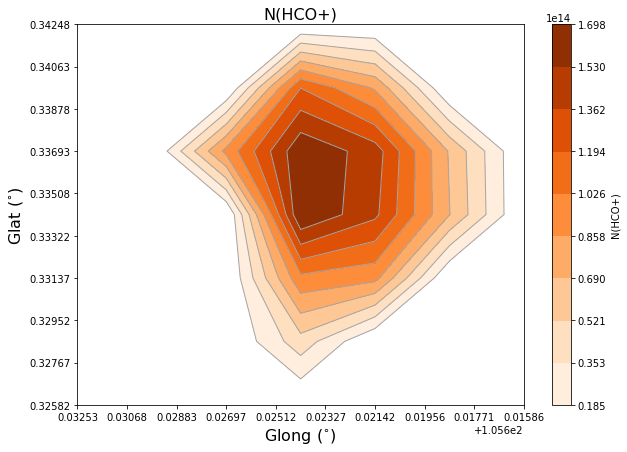

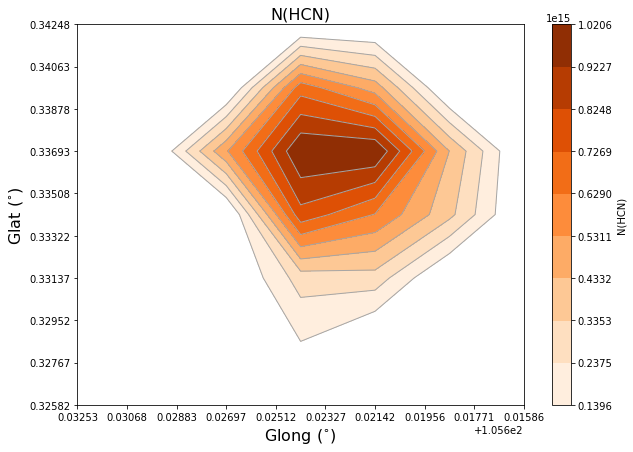

In [5]:
plots = []

breaksy = np.linspace(glatMin, glatMax, 10)
breaksx = np.linspace(glongMin, glongMax, 10)

### HCO+ Column Density ###

breaksHCO = np.linspace(m.floor(min(nAfloat)),m.ceil(max(nAfloat)),10) # can modify number of fill levels

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
CS1 = plt.contourf(v, u, hcoArray, breaksHCO, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksHCO, orientation='vertical')
cbar.set_label('N(HCO+)')

# contour lines
CS2 = plt.contour(v, u, hcoArray, breaksHCO, colors='0.65', linewidths=1)  # alt: replace colors with cmap='Oranges'

# level labels
# plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

#plt.grid(color='white', ls='dotted', lw=1)

plots.append(fig)



### HCN Column Density ###

breaksHCN = np.linspace(m.floor(min(nBfloat)),m.ceil(max(nBfloat)),10) # can modify number of fill levels

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
CS1 = plt.contourf(v, u, hcnArray, breaksHCN, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksHCN, orientation='vertical')
cbar.set_label('N(HCN)')

# contour lines
CS2 = plt.contour(v, u, hcnArray, breaksHCN, colors='0.65', linewidths=1)  # alt: replace colors with cmap='Oranges'

# level labels
# plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

#plt.grid(color='white', ls='dotted', lw=1)

plots.append(fig)



### Column Density Ratio ###

breaksRatio = np.linspace(m.floor(min(nTemp)),m.ceil(max(nTemp)),10) # can modify number of fill levels

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
CS1 = plt.contourf(v, u, largeArray, breaksRatio, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksRatio, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# contour lines
CS2 = plt.contour(v, u, largeArray, breaksRatio, colors='0.65', linewidths=1)  # alt: replace colors with cmap='Oranges' 

# level labels
# plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

#plt.grid(color='white', ls='dotted', lw=1)

plots.append(fig)



# saving the list containing all the plots to a pdf file
def save_multi_image(filename):
    pp = PdfPages(filename)
    for fig in plots:
        fig.savefig(pp, format='pdf')
    pp.close()

# path where pdf file will be saved
pdfplots = datadir+"coldenPlots.pdf"
save_multi_image(pdfplots) # Comment out if you do not want plots saved to PDF
print ('Column density plots written to', pdfplots) 


plt.show()

Plot saved to /Users/jane/Desktop/MAJORS/analysis/s138/ratioPlot_combined.png


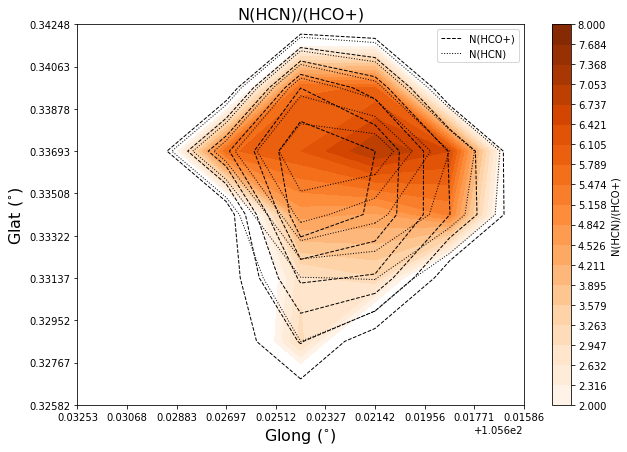

In [105]:
breaksHCO = np.linspace(m.floor(min(nAfloat)),m.ceil(max(nAfloat)),7) # can modify number of fill levels
breaksHCN = np.linspace(m.floor(min(nBfloat)),m.ceil(max(nBfloat)),7) # can modify number of fill levels
breaksRatio = np.linspace(m.floor(min(nTemp)),m.ceil(max(nTemp)),20) # can modify number of fill levels

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
CS1 = plt.contourf(v, u, largeArray, breaksRatio, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksRatio, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# contour lines
CS2 = plt.contour(v, u, hcoArray, breaksHCO, colors='k', linestyles='dashed', linewidths=1)
CS3 = plt.contour(v, u, hcnArray, breaksHCN, colors='k', linestyles='dotted', linewidths=1)

# legend
h1,_ = CS2.legend_elements()
h2,_ = CS3.legend_elements()
plt.legend([h1[0], h2[0]], ['N(HCO+)', 'N(HCN)'])

# level labels
# plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

#plt.grid(color='white', ls='dotted', lw=1)

# saving the figure
plt.savefig(datadir+'ratioPlot_combined.png')
print('Plot saved to', datadir+'ratioPlot_combined.png')

plt.show()

### Pixel contour plot

Column density plots written to /Users/jane/Desktop/MAJORS/analysis/s138/coldenPixelPlots.pdf


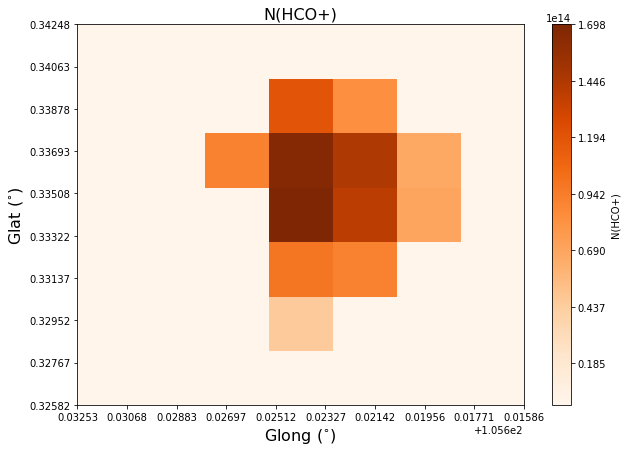

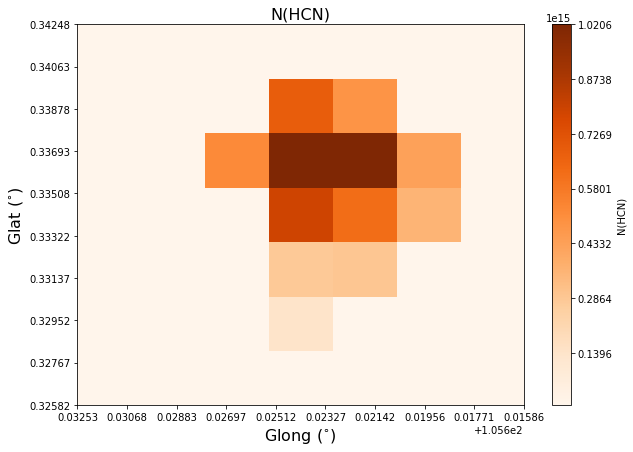

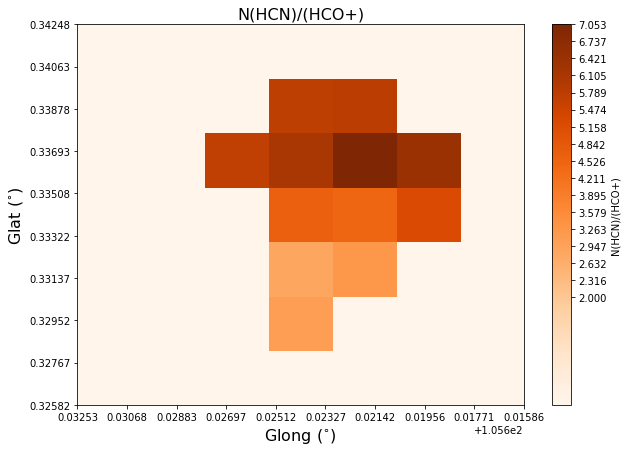

In [106]:
pixels = []

y = np.linspace(glatMin, glatMax, num=(len(savedglat)+1)) # y-axis
x = np.linspace(glongMin, glongMax, num=(len(savedglong)+1)) # x-axis


### HCO+ ###

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
plt.pcolormesh(x,y,hcoArray, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksHCO, orientation='vertical')
cbar.set_label('N(HCO+)')

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

pixels.append(fig)



### HCN ###

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
plt.pcolormesh(x,y,hcnArray, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksHCN, orientation='vertical')
cbar.set_label('N(HCN)')

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

pixels.append(fig)



### Ratio ###

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
plt.pcolormesh(x,y,largeArray, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksRatio, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

pixels.append(fig)


# saving the list containing all the plots to a pdf file
def save_multi_image(filename):
    pp = PdfPages(filename)
    for fig in pixels:
        fig.savefig(pp, format='pdf')
    pp.close()

# path where pdf file will be saved
pdfplots = datadir+"coldenPixelPlots.pdf"
save_multi_image(pdfplots) # Comment out if you do not want plots saved to PDF
print ('Column density plots written to', pdfplots) 



plt.show()

In [ ]:
# Turn warnings back on
warnings.filterwarnings('default')